## 알고리즘 전략의 위험 관리    

- 트레이딩 손실 리스크
- 규제 위반 리스크
- 스푸핑 Spoofing
- 호가 스터핑 Quote stuffing
- 종가 뱅잉 Banging the close
- 소프트웨어 구현 리스크
- DevOps 위험
- 시장 위험

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# 5장에서 csv파일로 저장한 데이터를 불러온다.

results = pd.read_csv('volatility_adjusted_mean_reversion.csv')
print(results.head(1))

         Date       Open       High      Low    Close  Adj Close    Volume  \
0  2019-01-02  50.828499  52.616001  50.7855  52.2925    52.2925  30652000   

   ClosePrice  Fast10DayEMA  Slow40DayEMA  APO  Trades  Position  Pnl  
0     52.2925       52.2925       52.2925  0.0       0         0  0.0  


In [2]:
results

,Date,Open,High,Low,Close,Adj Close,Volume,ClosePrice,Fast10DayEMA,Slow40DayEMA,APO,Trades,Position,Pnl
0,2019-01-02,50.828499,52.616001,50.785500,52.292500,52.292500,30652000,52.292500,52.292500,52.292500,0.000000,0,0,0.00000
1,2019-01-03,52.049999,52.848999,50.703499,50.803001,50.803001,36822000,50.803001,52.252162,52.281678,-0.029516,0,0,0.00000
2,2019-01-04,51.629501,53.542000,51.370899,53.535500,53.535500,41878000,53.535500,52.304291,52.295342,0.008949,0,0,0.00000
3,2019-01-07,53.575001,53.700001,52.737999,53.419498,53.419498,39638000,53.419498,52.348899,52.307406,0.041493,0,0,0.00000
4,2019-01-08,53.805500,54.228001,53.026501,53.813999,53.813999,35298000,53.813999,52.408200,52.323766,0.084434,0,0,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,2022-12-23,87.620003,90.099998,87.620003,89.809998,89.809998,17815000,89.809998,92.420055,96.178891,-3.758836,0,0,-6543.46464
1004,2022-12-27,89.309998,89.500000,87.535004,87.930000,87.930000,15470900,87.930000,91.715995,95.831864,-4.115870,0,0,-6543.46464
1005,2022-12-28,87.500000,88.519997,86.370003,86.459999,86.459999,17879600,86.459999,90.837249,95.411484,-4.574234,0,0,-6543.46464
1006,2022-12-29,87.029999,89.364998,86.989998,88.949997,88.949997,18280700,88.949997,90.540505,95.138903,-4.598399,0,0,-6543.46464


### 손절

주간 및 월간 손실 분포 확인

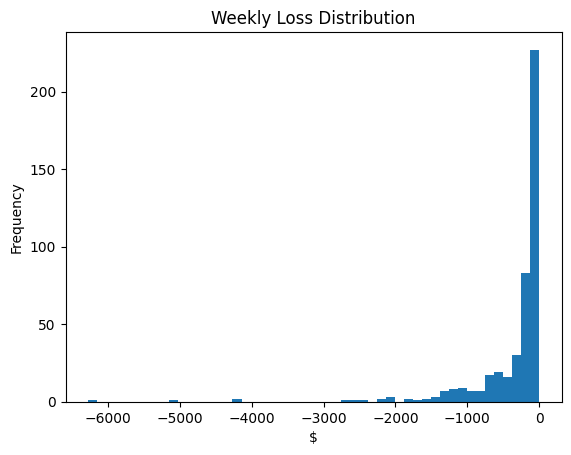

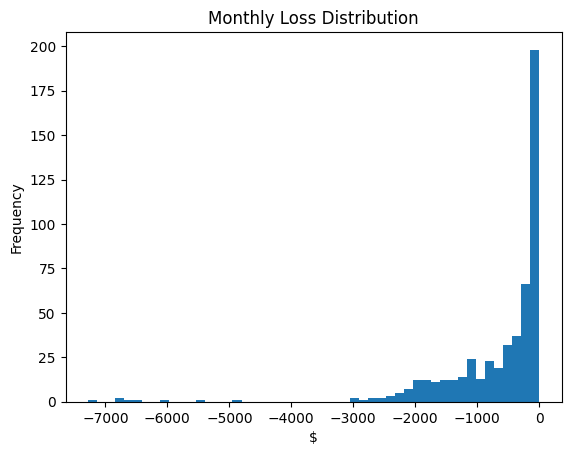

In [3]:
num_days = len(results.index)

pnl = results['Pnl']

weekly_losses = []
monthly_losses = []

for i in range(0, num_days):
  if i >= 5 and pnl[i - 5] > pnl[i]:
    weekly_losses.append(pnl[i] - pnl[i - 5])

  if i >= 20 and pnl[i - 20] > pnl[i]:
    monthly_losses.append(pnl[i] - pnl[i - 20])

plt.hist(weekly_losses, 50)
plt.gca().set(title='Weekly Loss Distribution', xlabel='$', ylabel='Frequency')
plt.show()

plt.hist(monthly_losses, 50)
plt.gca().set(title='Monthly Loss Distribution', xlabel='$', ylabel='Frequency')
plt.show()

### 최대 낙폭

전략이 특정 기간 동안 겪을 수 있는 최대 손실

Max Drawdown: 17099.164758000003


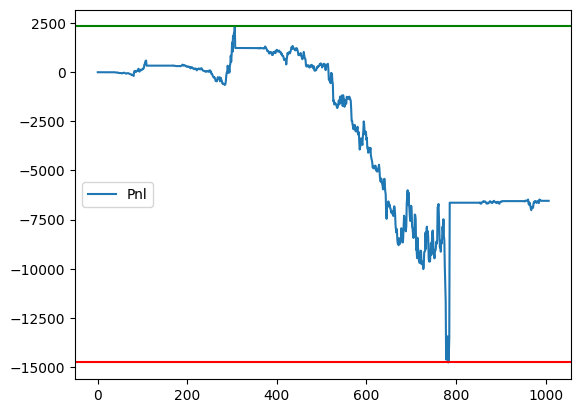

In [4]:
max_pnl = 0
max_drawdown = 0
drawdown_max_pnl = 0
drawdown_min_pnl = 0

for i in range(0, num_days):
  max_pnl = max(max_pnl, pnl[i])
  drawdown = max_pnl - pnl[i]

  if drawdown > max_drawdown:
    max_drawdown = drawdown
    drawdown_max_pnl = max_pnl
    drawdown_min_pnl = pnl[i]

print('Max Drawdown:', max_drawdown)

results['Pnl'].plot(x='Date', legend=True)
plt.axhline(y=drawdown_max_pnl, color='g')
plt.axhline(y=drawdown_min_pnl, color='r')
plt.show()

### 포지션 한도

전략의 포지션이 클수록 전략과 관련된 위험이 증가.
가능한 한 작은 포지션에 들어가면서 돈을 벌 수 있는 위험 찾기.

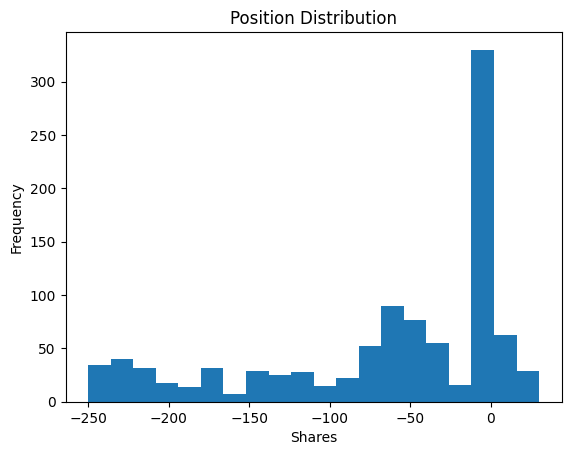

In [5]:
position = results['Position']
plt.hist(position, 20)
plt.gca().set(title='Position Distribution', xlabel='Shares', ylabel='Frequency')
plt.show()

### 포지션 보유기간

포지션을 열린 상태로 오래 보유할수록 포지션은 더 많은 위험 감수

[71, 140, 434, 52, 40]


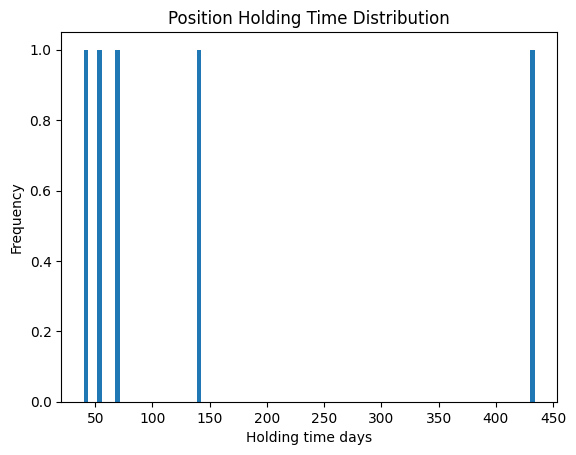

In [6]:
position_holding_times = []
current_pos = 0
current_pos_start = 0
for i in range(0, num_days):
  pos = results['Position'].iloc[i]

  # flat and starting a new position
  if current_pos == 0:
    if pos != 0:
      current_pos = pos
      current_pos_start = i
    continue

  # going from long position to flat or short position or
  # going from short position to flat or long position
  if current_pos * pos <= 0:
    current_pos = pos
    position_holding_times.append(i - current_pos_start)
    current_pos_start = i

print(position_holding_times)
plt.hist(position_holding_times, 100)
plt.gca().set(title='Position Holding Time Distribution', xlabel='Holding time days', ylabel='Frequency')
plt.show()

### PnL 분산

투자 기간으로 선택한 기간에 대한 수익률 표준편차 standard deviation of returns를 계산.

PnL과 수익률 표준편차 간의 균형으로 최적의 트레이딩 성과 찾기.

오른쪽으로 치우쳐 있는 분포 ==> 양의 누적 PnL 산출.

PnL Standard Deviation: 739.89326469098


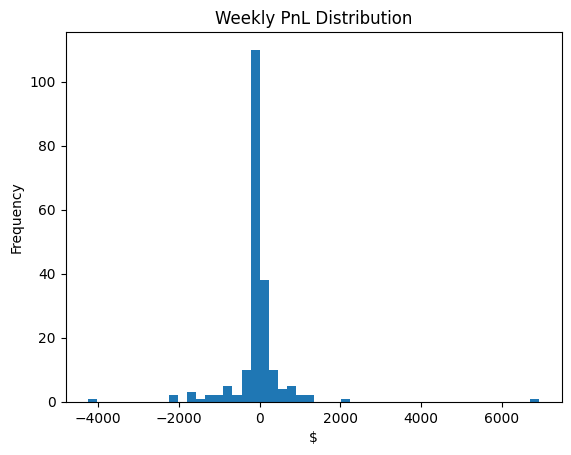

In [7]:
last_week = 0
weekly_pnls = []
weekly_losses = []
for i in range(0, num_days):
  if i - last_week >= 5:
    pnl_change = pnl[i] - pnl[last_week]
    weekly_pnls.append(pnl_change)
    if pnl_change < 0:
      weekly_losses.append(pnl_change)
    last_week = i

from statistics import stdev, mean
print('PnL Standard Deviation:', stdev(weekly_pnls))

plt.hist(weekly_pnls, 50)
plt.gca().set(title='Weekly PnL Distribution', xlabel='$', ylabel='Frequency')
plt.show()

### 샤프 비율

일평균 손익 / 일별 손익의 표준편차

In [ ]:
# 샤프비율과 소르티노 비율 (소르티노 비율은 돈을 잃는 경우에만 관측한다.)

In [8]:
'''
last_week = 0
weekly_pnls = []
weekly_losses = []
for i in range(0, num_days):
  if i - last_week >= 5:
    pnl_change = pnl[i] - pnl[last_week]
    weekly_pnls.append(pnl_change)
    if pnl_change < 0:
      weekly_losses.append(pnl_change)
    last_week = i

from statistics import stdev, mean
'''
sharpe_ratio = mean(weekly_pnls) / stdev(weekly_pnls)
sortino_ratio = mean(weekly_pnls) / stdev(weekly_losses)

print('Sharpe ratio:', sharpe_ratio)
print('Sortino ratio:', sortino_ratio)

Sharpe ratio: -0.043998982017166725
Sortino ratio: -0.050895516635295304


### 기간별 최대 체결수
- 구간 기반 위험 검사
- 주어진 기간 동안 허용된 최대 거래 수 측정.
- 매우 빠른 속도로 사고 파는 폭주 전략 감지.

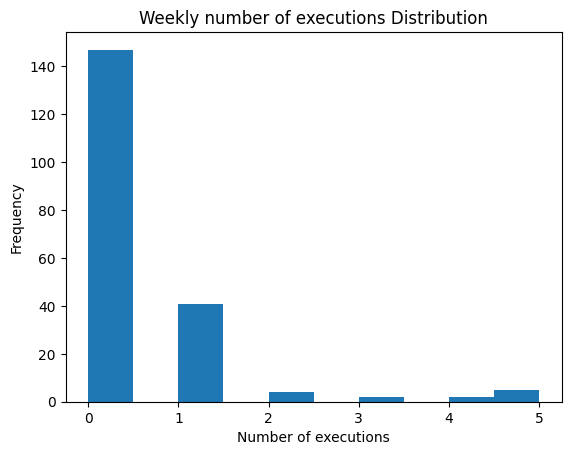

In [9]:
executions_this_week = 0
executions_per_week = []
last_week = 0
for i in range(0, num_days):
  if results['Trades'].iloc[i] != 0:
    executions_this_week += 1

  if i - last_week >= 5:
    executions_per_week.append(executions_this_week)
    executions_this_week = 0
    last_week = i

plt.hist(executions_per_week, 10)
plt.gca().set(title='Weekly number of executions Distribution', xlabel='Number of executions', ylabel='Frequency')
plt.show()

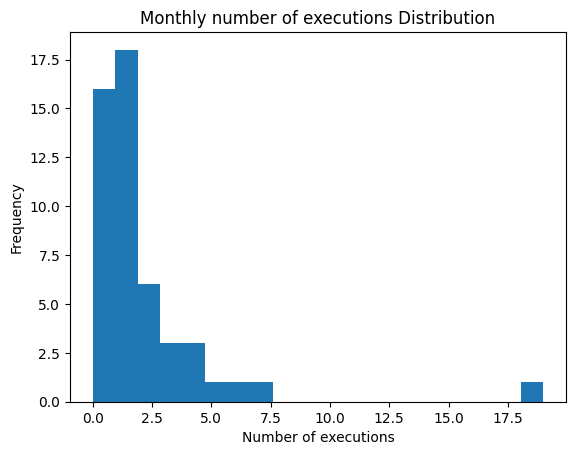

In [10]:
executions_this_month = 0
executions_per_month = []
last_month = 0
for i in range(0, num_days):
  if results['Trades'].iloc[i] != 0:
    executions_this_month += 1

  if i - last_month >= 20:
    executions_per_month.append(executions_this_month)
    executions_this_month = 0
    last_month = i

plt.hist(executions_per_month, 20)
plt.gca().set(title='Monthly number of executions Distribution', xlabel='Number of executions', ylabel='Frequency')
plt.show()

### 최대 거래 규모
- 거래량 측정

In [11]:
traded_volume = 0
for i in range(0, num_days):
  if results['Trades'].iloc[i] != 0:
    traded_volume += abs(results['Position'].iloc[i] - results['Position'].iloc[i-1])

print('Total traded volume:', traded_volume)

Total traded volume: 880


## 리스크 관리 알고리즘 구축 (A)

### 주간, 월간 최대 낙폭 계산

In [27]:
results['Date'] = pd.to_datetime(results['Date'])
weekly_grouped_Pnl = results.groupby(results['Date'].dt.to_period('W'))['Pnl'].sum()
monthly_grouped_Pnl = results.groupby(results['Date'].dt.to_period('M'))['Pnl'].sum()

In [28]:
weekly_grouped_Pnl

Date
2018-12-31/2019-01-06        0.000000
2019-01-07/2019-01-13        0.000000
2019-01-14/2019-01-20        0.000000
2019-01-21/2019-01-27        0.000000
2019-01-28/2019-02-03        0.000000
                             ...     
2022-11-28/2022-12-04   -32780.290037
2022-12-05/2022-12-11   -32691.723150
2022-12-12/2022-12-18   -32717.323200
2022-12-19/2022-12-25   -32717.323200
2022-12-26/2023-01-01   -26173.858560
Freq: W-SUN, Name: Pnl, Length: 209, dtype: float64

In [29]:
# 주간 그룹화된 Pnl 데이터로 최대 낙폭 계산
max_pnl_weekly = 0
max_drawdown_weekly = 0
drawdown_max_pnl_weekly = 0
drawdown_min_pnl_weekly = 0

for i in range(0, len(weekly_grouped_Pnl)):
    max_pnl_weekly = max(max_pnl_weekly, weekly_grouped_Pnl[i])
    drawdown = max_pnl_weekly - weekly_grouped_Pnl[i]
    
    if drawdown > max_drawdown_weekly:
        max_drawdown_weekly = drawdown
        drawdown_max_pnl_weekly = max_pnl_weekly
        drawdown_min_pnl_weekly = weekly_grouped_Pnl[i]

# 월간 그룹화된 Pnl 데이터로 최대 낙폭 계산
max_pnl_monthly = 0
max_drawdown_monthly = 0
drawdown_max_pnl_monthly = 0
drawdown_min_pnl_monthly = 0

for i in range(0, len(monthly_grouped_Pnl)):
    max_pnl_monthly = max(max_pnl_monthly, monthly_grouped_Pnl[i])
    drawdown = max_pnl_monthly - monthly_grouped_Pnl[i]
    
    if drawdown > max_drawdown_monthly:
        max_drawdown_monthly = drawdown
        drawdown_max_pnl_monthly = max_pnl_monthly
        drawdown_min_pnl_monthly = monthly_grouped_Pnl[i]

print("주간 최대 낙폭:", max_drawdown_weekly)
print("주간 최대 낙폭 발생 시 최대 Pnl:", drawdown_max_pnl_weekly)
print("주간 최대 낙폭 발생 시 최소 Pnl:", drawdown_min_pnl_weekly)

print("월간 최대 낙폭:", max_drawdown_monthly)
print("월간 최대 낙폭 발생 시 최대 Pnl:", drawdown_max_pnl_monthly)
print("월간 최대 낙폭 발생 시 최소 Pnl:", drawdown_min_pnl_monthly)


주간 최대 낙폭: 79908.87578
주간 최대 낙폭 발생 시 최대 Pnl: 9897.517559999998
주간 최대 낙폭 발생 시 최소 Pnl: -70011.35822000001
월간 최대 낙폭: 222187.68484999996
월간 최대 낙폭 발생 시 최대 Pnl: 27067.19055999998
월간 최대 낙폭 발생 시 최소 Pnl: -195120.49428999997


### 포지션 최대 한도 계산

In [52]:
Position=results['Position'].describe()

### 포지션 보유기간 계산

In [45]:
position_holding_times = []
current_pos = 0
current_pos_start = 0
for i in range(0, num_days):
  pos = results['Position'].iloc[i]

  # flat and starting a new position
  if current_pos == 0:
    if pos != 0:
      current_pos = pos
      current_pos_start = i
    continue

  # going from long position to flat or short position or
  # going from short position to flat or long position
  if current_pos * pos <= 0:
    current_pos = pos
    position_holding_times.append(i - current_pos_start)
    current_pos_start = i

print(position_holding_times)

[71, 140, 434, 52, 40]


### 최대 거래 규모

In [51]:
traded_volume = 0
for i in range(0, num_days):
  if results['Trades'].iloc[i] != 0:
    traded_volume += abs(results['Position'].iloc[i] - results['Position'].iloc[i-1])

print('Total traded volume:', traded_volume)

Total traded volume: 880


## 리스크 관련 알고리즘 구축 (B)

In [57]:
# 데이터 불러오기 (5장과 동일)

import pandas as pd
import numpy as np
import FinanceDataReader as fdr

start_date = '2019-01-01'
end_date = '2023-01-01'

data = fdr.DataReader('GOOG', start_date, end_date)

# EMA 계산을 위한 변수 / 상수
NUM_PERIODS_FAST = 10 
K_FAST = 2 / (NUM_PERIODS_FAST + 1) 
ema_fast = 0
ema_fast_values = [] 

NUM_PERIODS_SLOW = 40 
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) 
ema_slow = 0
ema_slow_values = [] 

apo_values = [] 

# 포지션과 손익계산을 위한 변수
orders = [] 
positions = [] 
pnls = [] 

last_buy_price = 0 
last_sell_price = 0 
position = 0 
buy_sum_price_qty = 0 
buy_sum_qty = 0 
sell_sum_price_qty = 0 
sell_sum_qty = 0 
open_pnl = 0 
closed_pnl = 0 

# 트레이딩 전략 구현을 위한 상수
APO_VALUE_FOR_BUY_ENTRY = -10 
APO_VALUE_FOR_SELL_ENTRY = 10 
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10
NUM_SHARES_PER_TRADE = 10 
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE

import statistics as stats
import math as math

# Constants/variables that are used to compute standard deviation as a volatility measure
SMA_NUM_PERIODS = 20  # look back period
price_history = []  # history of prices

In [69]:
# 알고리즘 구축 (A) 에서 계산한 값 불러오기

RISK_LIMIT_WEEKLY_STOP_LOSS = max_drawdown_weekly * 1.5
RISK_LIMIT_MONTHLY_STOP_LOSS = max_drawdown_monthly * 1.5
RISK_LIMIT_MAX_POSITION = max(Position) * 1.5
RISK_LIMIT_MAX_POSITION_HOLDING_TIME_DAYS = max(position_holding_times) * 1.5
RISK_LIMIT_MAX_TRADE_SIZE = 10 * 1.5
RISK_LIMIT_MAX_TRADED_VOLUME = traded_volume * 1.5

In [59]:
# 위험 위반을 추적하기 위한 변수
risk_violated = False

traded_volume = 0
current_pos = 0
current_pos_start = 0

In [ ]:
# 거래 전략 예시. 앞장에서 살펴본 회귀 거래 시그널 이용한다.

close = data['Close']
for close_price in close:
  price_history.append(close_price)
  if len(price_history) > SMA_NUM_PERIODS:  # 적어도 설정된 기간의 가격 수만큼 추정
    del (price_history[0])

  sma = stats.mean(price_history)
  variance = 0 
  for hist_price in price_history:
    variance = variance + ((hist_price - sma) ** 2)

  stdev = math.sqrt(variance / len(price_history))
  stdev_factor = stdev / 15
  if stdev_factor == 0:
    stdev_factor = 1

  # Slow/Fast EMA 업데이트, APO 트레이딩 시그널 계산
  if (ema_fast == 0):  
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_FAST * stdev_factor + ema_fast
    ema_slow = (close_price - ema_slow) * K_SLOW * stdev_factor + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)

  apo = ema_fast - ema_slow
  apo_values.append(apo)
  # 시도할 거래 규모가 MAX_TRADE_SIZE 한도 내에 있는지 확인.
  if NUM_SHARES_PER_TRADE > RISK_LIMIT_MAX_TRADE_SIZE:
    print('RiskViolation NUM_SHARES_PER_TRADE', NUM_SHARES_PER_TRADE, ' > RISK_LIMIT_MAX_TRADE_SIZE', RISK_LIMIT_MAX_TRADE_SIZE )
    risk_violated = True

      # 이후 조건들은 앞장과 동일하게 복붙하여 진행.

  # 다음 조건을 만족하면 종가로 매도 거래 수행.
  if (not risk_violated and
      ((apo > APO_VALUE_FOR_SELL_ENTRY * stdev_factor and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE * stdev_factor)  
       or
       (position > 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE / stdev_factor)))):  
    orders.append(-1)  
    last_sell_price = close_price
    position -= NUM_SHARES_PER_TRADE  
    sell_sum_price_qty += (close_price * NUM_SHARES_PER_TRADE)  
    sell_sum_qty += NUM_SHARES_PER_TRADE
    traded_volume += NUM_SHARES_PER_TRADE
    print("Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)

  # 다음 조건을 만족하면 종가로 매수 거래를 수행 
  elif (not risk_violated and
        ((apo < APO_VALUE_FOR_BUY_ENTRY * stdev_factor and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE * stdev_factor)  
         or
         (position < 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE / stdev_factor)))):  
    orders.append(+1)  
    last_buy_price = close_price
    position += NUM_SHARES_PER_TRADE 
    buy_sum_price_qty += (close_price * NUM_SHARES_PER_TRADE)  
    buy_sum_qty += NUM_SHARES_PER_TRADE
    traded_volume += NUM_SHARES_PER_TRADE
    print("Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)
  else:
    
    orders.append(0)

  positions.append(position)

  # 기존 포지션을 청산하고 새로운 포지션을 시작.
  if current_pos == 0:
    if position != 0:
      current_pos = position
      current_pos_start = len(positions)
  
  elif current_pos * position <= 0:
    current_pos = position
    position_holding_time = len(positions) - current_pos_start
    current_pos_start = len(positions)

    if position_holding_time > RISK_LIMIT_MAX_POSITION_HOLDING_TIME_DAYS:
      print('RiskViolation position_holding_time', position_holding_time, ' > RISK_LIMIT_MAX_POSITION_HOLDING_TIME_DAYS', RISK_LIMIT_MAX_POSITION_HOLDING_TIME_DAYS)
      risk_violated = True

  if abs(position) > RISK_LIMIT_MAX_POSITION:
    print('RiskViolation position', position, ' > RISK_LIMIT_MAX_POSITION', RISK_LIMIT_MAX_POSITION)
    risk_violated = True

  if traded_volume > RISK_LIMIT_MAX_TRADED_VOLUME:
    print('RiskViolation traded_volume', traded_volume, ' > RISK_LIMIT_MAX_TRADED_VOLUME', RISK_LIMIT_MAX_TRADED_VOLUME)
    risk_violated = True

  # PNL 업데이트 코드
  open_pnl = 0
  if position > 0:
    if sell_sum_qty > 0:  
      open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
    
    open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
  elif position < 0:
    if buy_sum_qty > 0: 
      open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
    
    open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty / sell_sum_qty - close_price)
  else:
    
    closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
    buy_sum_price_qty = 0
    buy_sum_qty = 0
    sell_sum_price_qty = 0
    sell_sum_qty = 0
    last_buy_price = 0
    last_sell_price = 0

  print("OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl))
  pnls.append(closed_pnl + open_pnl)
  # 실현 및 미실현 PnL의 합인 총 PnL이 "최대 허용 주간 손절 한도"나 "최대 허용 원간 손절 한도"를 위반하지 않는지 체크
  if len(pnls) > 5:
    weekly_loss = pnls[-1] - pnls[-6]

    if weekly_loss < RISK_LIMIT_WEEKLY_STOP_LOSS:
      print('RiskViolation weekly_loss', weekly_loss, ' < RISK_LIMIT_WEEKLY_STOP_LOSS', RISK_LIMIT_WEEKLY_STOP_LOSS)
      risk_violated = True

  if len(pnls) > 20:
    monthly_loss = pnls[-1] - pnls[-21]

    if monthly_loss < RISK_LIMIT_MONTHLY_STOP_LOSS:
      print('RiskViolation monthly_loss', monthly_loss, ' < RISK_LIMIT_MONTHLY_STOP_LOSS', RISK_LIMIT_MONTHLY_STOP_LOSS)
      risk_violated = True


## 동적 위험 조정

- 좋은 달 후에 거래 규모와 위험을 증가시키고, 나쁜 달 후에 거래 규모와 위험을 조금씩 줄임

In [84]:
# 데이터 불러오는 과정은 앞장의 과정과 동일하게 진행한다.
# 트레이딩 전략 역시 기존과 같다.
# 다만 위험의 수준을 동적으로 변화시켜주기 위해 변형이 들어갔다.
# 상당히 긴 코드와 앞 장과 중복되는 코드가 많아 전체 코드는 저자의 깃허브에서 가져왔다.
# 수익이 음인 달 이후 거래 규모 및 최대 거래 규모 위험 한도가 줄어드는 것을 확인하자.

OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  Clo

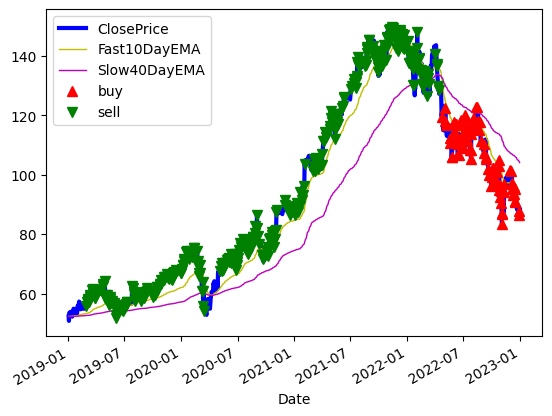

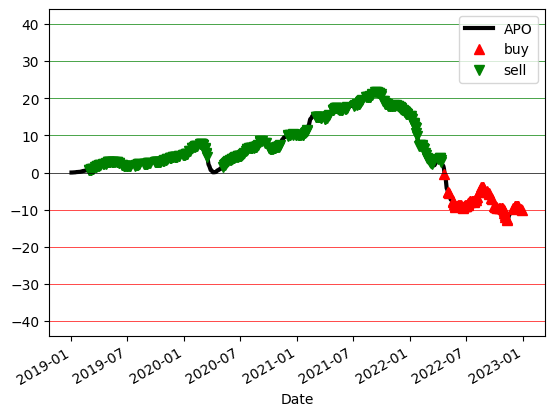

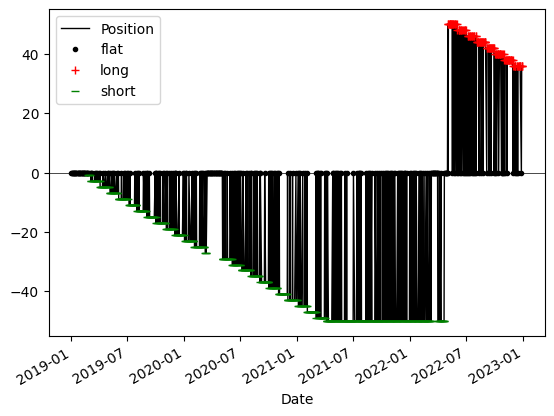

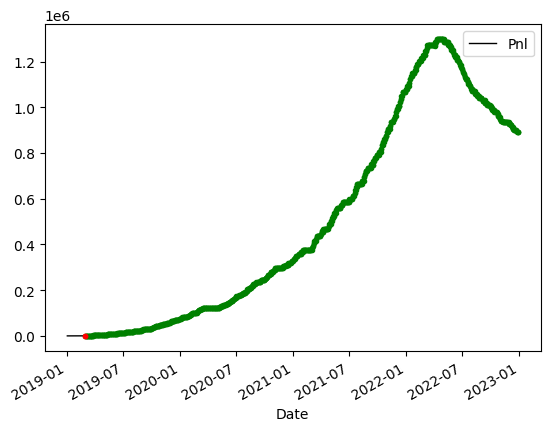

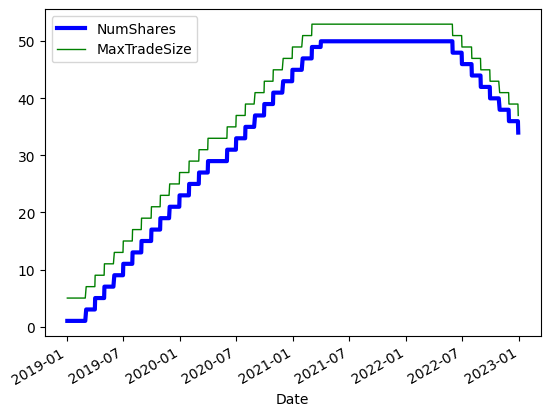

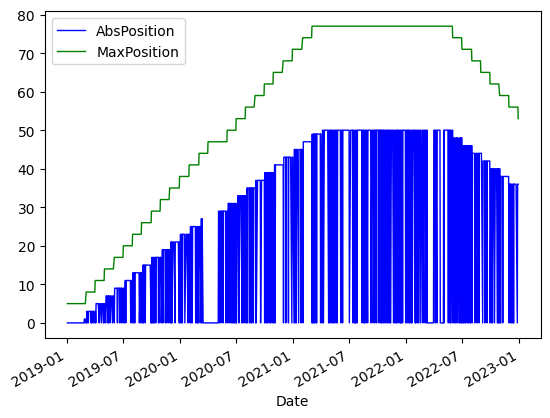

In [85]:
# Variables/constants for EMA Calculation:
NUM_PERIODS_FAST = 10  # Static time period parameter for the fast EMA
K_FAST = 2 / (NUM_PERIODS_FAST + 1)  # Static smoothing factor parameter for fast EMA
ema_fast = 0
ema_fast_values = []  # we will hold fast EMA values for visualization purposes

NUM_PERIODS_SLOW = 40  # Static time period parameter for slow EMA
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1)  # Static smoothing factor parameter for slow EMA
ema_slow = 0
ema_slow_values = []  # we will hold slow EMA values for visualization purposes

apo_values = []  # track computed absolute price oscillator value signals

# Variables for Trading Strategy trade, position & pnl management:
orders = []  # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = []  # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = []  # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buy_price = 0  # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0  # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0  # Current position of the trading strategy
buy_sum_price_qty = 0  # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0  # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0  # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0  # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0  # Open/Unrealized PnL marked to market
closed_pnl = 0  # Closed/Realized PnL so far

# Constants that define strategy behavior/thresholds
APO_VALUE_FOR_BUY_ENTRY = -10  # APO trading signal value below which to enter buy-orders/long-position
APO_VALUE_FOR_SELL_ENTRY = 10  # APO trading signal value above which to enter sell-orders/short-position
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10  # Minimum price change since last trade before considering trading again, this is to prevent over-trading at/around same prices

MIN_NUM_SHARES_PER_TRADE = 1
MAX_NUM_SHARES_PER_TRADE = 50
INCREMENT_NUM_SHARES_PER_TRADE = 2
num_shares_per_trade = MIN_NUM_SHARES_PER_TRADE  # Beginning number of shares to buy/sell on every trade
num_shares_history = [] # history of num-shares
abs_position_history = [] # history of absolute-position

import statistics as stats
import math as math

# Constants/variables that are used to compute standard deviation as a volatility measure
SMA_NUM_PERIODS = 20  # look back period
price_history = []  # history of prices

# Risk limits and increments to risk limits when we have good/bad months
risk_limit_weekly_stop_loss = -6000
INCREMENT_RISK_LIMIT_WEEKLY_STOP_LOSS = -12000
risk_limit_monthly_stop_loss = -15000
INCREMENT_RISK_LIMIT_MONTHLY_STOP_LOSS = -30000
risk_limit_max_position = 5
INCREMENT_RISK_LIMIT_MAX_POSITION = 3
max_position_history = [] # history of max-trade-size
RISK_LIMIT_MAX_POSITION_HOLDING_TIME_DAYS = 120 * 5
risk_limit_max_trade_size = 5
INCREMENT_RISK_LIMIT_MAX_TRADE_SIZE = 2
max_trade_size_history = [] # history of max-trade-size

risk_violated = False

traded_volume = 0
current_pos = 0
current_pos_start = 0
last_risk_change_index = 0

close = data['Close']
for close_price in close:
  price_history.append(close_price)
  if len(price_history) > SMA_NUM_PERIODS:  # we track at most 'time_period' number of prices
    del (price_history[0])

  sma = stats.mean(price_history)
  variance = 0  # variance is square of standard deviation
  for hist_price in price_history:
    variance = variance + ((hist_price - sma) ** 2)

  stdev = math.sqrt(variance / len(price_history))
  stdev_factor = stdev / 15
  if stdev_factor == 0:
    stdev_factor = 1

  # This section updates fast and slow EMA and computes APO trading signal
  if (ema_fast == 0):  # first observation
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_FAST * stdev_factor + ema_fast
    ema_slow = (close_price - ema_slow) * K_SLOW * stdev_factor + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)

  apo = ema_fast - ema_slow
  apo_values.append(apo)

  if num_shares_per_trade > risk_limit_max_trade_size:
    print('RiskViolation num_shares_per_trade', num_shares_per_trade, ' > risk_limit_max_trade_size', risk_limit_max_trade_size )
    risk_violated = True

  MIN_PROFIT_TO_CLOSE = num_shares_per_trade * 10

  # This section checks trading signal against trading parameters/thresholds and positions, to trade.

  # We will perform a sell trade at close_price if the following conditions are met:
  # 1. The APO trading signal value is above Sell-Entry threshold and the difference between last trade-price and current-price is different enough.
  # 2. We are long( +ve position ) and either APO trading signal value is at or above 0 or current position is profitable enough to lock profit.
  if (not risk_violated and
      ((apo > APO_VALUE_FOR_SELL_ENTRY * stdev_factor and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE * stdev_factor)  # APO above sell entry threshold, we should sell
       or
       (position > 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE / stdev_factor)))):  # long from -ve APO and APO has gone positive or position is profitable, sell to close position
    orders.append(-1)  # mark the sell trade
    last_sell_price = close_price
    if position == 0: # opening a new entry position
      position -= num_shares_per_trade  # reduce position by the size of this trade
      sell_sum_price_qty += (close_price * num_shares_per_trade)  # update vwap sell-price
      sell_sum_qty += num_shares_per_trade
      traded_volume += num_shares_per_trade
      print("Sell ", num_shares_per_trade, " @ ", close_price, "Position: ", position)
    else: # closing an existing position
      sell_sum_price_qty += (close_price * abs(position))  # update vwap sell-price
      sell_sum_qty += abs(position)
      traded_volume += abs(position)
      print("Sell ", abs(position), " @ ", close_price, "Position: ", position)
      position = 0  # reduce position by the size of this trade

  # We will perform a buy trade at close_price if the following conditions are met:
  # 1. The APO trading signal value is below Buy-Entry threshold and the difference between last trade-price and current-price is different enough.
  # 2. We are short( -ve position ) and either APO trading signal value is at or below 0 or current position is profitable enough to lock profit.
  elif (not risk_violated and
        ((apo < APO_VALUE_FOR_BUY_ENTRY * stdev_factor and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE * stdev_factor)  # APO below buy entry threshold, we should buy
         or
         (position < 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE / stdev_factor)))):  # short from +ve APO and APO has gone negative or position is profitable, buy to close position
    orders.append(+1)  # mark the buy trade
    last_buy_price = close_price
    if position == 0: # opening a new entry position
      position += num_shares_per_trade  # increase position by the size of this trade
      buy_sum_price_qty += (close_price * num_shares_per_trade)  # update the vwap buy-price
      buy_sum_qty += num_shares_per_trade
      traded_volume += num_shares_per_trade
      print("Buy ", num_shares_per_trade, " @ ", close_price, "Position: ", position)
    else: # closing an existing position
      buy_sum_price_qty += (close_price * abs(position))  # update the vwap buy-price
      buy_sum_qty += abs(position)
      traded_volume += abs(position)
      print("Buy ", abs(position), " @ ", close_price, "Position: ", position)
      position = 0  # increase position by the size of this trade
  else:
    # No trade since none of the conditions were met to buy or sell
    orders.append(0)

  positions.append(position)

  # flat and starting a new position
  if current_pos == 0:
    if position != 0:
      current_pos = position
      current_pos_start = len(positions)
  # going from long position to flat or short position or
  # going from short position to flat or long position
  elif current_pos * position <= 0:
    current_pos = position
    position_holding_time = len(positions) - current_pos_start
    current_pos_start = len(positions)

    if position_holding_time > RISK_LIMIT_MAX_POSITION_HOLDING_TIME_DAYS:
      print('RiskViolation position_holding_time', position_holding_time, ' > RISK_LIMIT_MAX_POSITION_HOLDING_TIME_DAYS', RISK_LIMIT_MAX_POSITION_HOLDING_TIME_DAYS)
      risk_violated = True

  if abs(position) > risk_limit_max_position:
    print('RiskViolation position', position, ' > risk_limit_max_position', risk_limit_max_position)
    risk_violated = True

  # This section updates Open/Unrealized & Closed/Realized positions
  open_pnl = 0
  if position > 0:
    if sell_sum_qty > 0:  # long position and some sell trades have been made against it, close that amount based on how much was sold against this long position
      open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
    # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
    open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
  elif position < 0:
    if buy_sum_qty > 0:  # short position and some buy trades have been made against it, close that amount based on how much was bought against this short position
      open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
    # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
    open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty / sell_sum_qty - close_price)
  else:
    # flat, so update closed_pnl and reset tracking variables for positions & pnls
    closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
    buy_sum_price_qty = 0
    buy_sum_qty = 0
    sell_sum_price_qty = 0
    sell_sum_qty = 0
    last_buy_price = 0
    last_sell_price = 0

  print("OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl))
  pnls.append(closed_pnl + open_pnl)

  # Analyze monthly performance and adjust risk up/down
  if len(pnls) > 20:
    monthly_pnls = pnls[-1] - pnls[-20]

    if len(pnls) - last_risk_change_index > 20:
      if monthly_pnls > 0:
        num_shares_per_trade += INCREMENT_NUM_SHARES_PER_TRADE
        if num_shares_per_trade <= MAX_NUM_SHARES_PER_TRADE:
          print('Increasing trade-size and risk')
          risk_limit_weekly_stop_loss += INCREMENT_RISK_LIMIT_WEEKLY_STOP_LOSS
          risk_limit_monthly_stop_loss += INCREMENT_RISK_LIMIT_MONTHLY_STOP_LOSS
          risk_limit_max_position += INCREMENT_RISK_LIMIT_MAX_POSITION
          risk_limit_max_trade_size += INCREMENT_RISK_LIMIT_MAX_TRADE_SIZE
        else:
          num_shares_per_trade = MAX_NUM_SHARES_PER_TRADE
      elif monthly_pnls < 0:
        num_shares_per_trade -= INCREMENT_NUM_SHARES_PER_TRADE
        if num_shares_per_trade >= MIN_NUM_SHARES_PER_TRADE:
          print('Decreasing trade-size and risk')
          risk_limit_weekly_stop_loss -= INCREMENT_RISK_LIMIT_WEEKLY_STOP_LOSS
          risk_limit_monthly_stop_loss -= INCREMENT_RISK_LIMIT_MONTHLY_STOP_LOSS
          risk_limit_max_position -= INCREMENT_RISK_LIMIT_MAX_POSITION
          risk_limit_max_trade_size -= INCREMENT_RISK_LIMIT_MAX_TRADE_SIZE
        else:
          num_shares_per_trade = MIN_NUM_SHARES_PER_TRADE

      last_risk_change_index = len(pnls)

  # Track trade-sizes/positions and risk limits as they evolve over time
  num_shares_history.append(num_shares_per_trade)
  abs_position_history.append(abs(position))
  max_trade_size_history.append(risk_limit_max_trade_size)
  max_position_history.append(risk_limit_max_position)

  if len(pnls) > 5:
    weekly_loss = pnls[-1] - pnls[-6]

    if weekly_loss < risk_limit_weekly_stop_loss:
      print('RiskViolation weekly_loss', weekly_loss, ' < risk_limit_weekly_stop_loss', risk_limit_weekly_stop_loss)
      risk_violated = True

  if len(pnls) > 20:
    monthly_loss = pnls[-1] - pnls[-21]

    if monthly_loss < risk_limit_monthly_stop_loss:
      print('RiskViolation monthly_loss', monthly_loss, ' < risk_limit_monthly_stop_loss', risk_limit_monthly_stop_loss)
      risk_violated = True

# This section prepares the dataframe from the trading strategy results and visualizes the results
data = data.assign(ClosePrice=pd.Series(close, index=data.index))
data = data.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=data.index))
data = data.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=data.index))
data = data.assign(APO=pd.Series(apo_values, index=data.index))
data = data.assign(Trades=pd.Series(orders, index=data.index))
data = data.assign(Position=pd.Series(positions, index=data.index))
data = data.assign(Pnl=pd.Series(pnls, index=data.index))
data = data.assign(NumShares=pd.Series(num_shares_history, index=data.index))
data = data.assign(MaxTradeSize=pd.Series(max_trade_size_history, index=data.index))
data = data.assign(AbsPosition=pd.Series(abs_position_history, index=data.index))
data = data.assign(MaxPosition=pd.Series(max_position_history, index=data.index))

import matplotlib.pyplot as plt

data['ClosePrice'].plot(color='blue', lw=3., legend=True)
data['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
data['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.ClosePrice[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.ClosePrice[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

data['APO'].plot(color='k', lw=3., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.APO[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.APO[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

data['Position'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Position == 0 ].index, data.Position[ data.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(data.loc[ data.Position > 0 ].index, data.Position[ data.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(data.loc[ data.Position < 0 ].index, data.Position[ data.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
plt.legend()
plt.show()

data['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Pnl > 0 ].index, data.Pnl[ data.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(data.loc[ data.Pnl < 0 ].index, data.Pnl[ data.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()

data['NumShares'].plot(color='b', lw=3., legend=True)
data['MaxTradeSize'].plot(color='g', lw=1., legend=True)
plt.legend()
plt.show()

data['AbsPosition'].plot(color='b', lw=1., legend=True)
data['MaxPosition'].plot(color='g', lw=1., legend=True)
plt.legend()
plt.show()